In [2]:
import numpy as np
from dataclasses import dataclass
from typing import List, Literal, Dict
import matplotlib.pyplot as plt

In [3]:
# Define a type alias for buy/sell side
Side = Literal["buy", "sell"]

@dataclass
class OrderBookSnapshot:
    """Represents a snapshot of a limit order book (LOB)."""
    ask_prices: List[float]   # best to worse (ascending)
    ask_sizes:  List[int]     # same length as ask_prices
    bid_prices: List[float]   # best to worse (descending)
    bid_sizes:  List[int]     # same length as bid_prices

    def best_ask(self) -> float:
        """Returns the best ask price."""
        return float(self.ask_prices[0])

    def best_bid(self) -> float:
        """Returns the best bid price."""
        return float(self.bid_prices[0])

    def mid(self) -> float:
        """Calculates the mid-price."""
        return 0.5 * (self.best_ask() + self.best_bid())

    def half_spread(self) -> float:
        """Calculates the half-spread."""
        return 0.5 * (self.best_ask() - self.best_bid())

    def depth_scale(self, side: Side, top_k: int = 3) -> float:
        """Calculates a simple depth scale (D_t) by summing the sizes
           across the top K levels on the side you will consume."""
        if side == "buy":
            return float(np.sum(self.ask_sizes[:min(top_k, len(self.ask_sizes))]))
        else: # "sell"
            return float(np.sum(self.bid_sizes[:min(top_k, len(self.bid_sizes))]))

In [4]:
def _vwap_from_book(prices: np.ndarray, sizes: np.ndarray, x: float) -> float:
    """
    Calculates the Volume-Weighted Average Price (VWAP) of consuming a quantity x
    from a discrete order book ladder.
    """
    if x <= 0:
        raise ValueError("Order quantity x must be positive.")
    
    cum_sizes = np.cumsum(sizes)
    
    # Find the index of the level where the order will be filled.
    # np.searchsorted with 'right' finds the first index `i` where cum_sizes[i] >= x.
    idx = np.searchsorted(cum_sizes, x, side="right")
    
    if idx == 0:
        # The entire order is filled within the first level.
        # FIX: Replaced undefined 'take_last' with 'x'.
        cost = prices[0] * x
    else:
        # Cost of the fully consumed levels (from 0 to idx-1).
        full_levels_cost = np.sum(prices[:idx] * sizes[:idx])
        
        # Quantity that remains to be filled from the partial level.
        leftover = x - cum_sizes[idx-1]
        
        # FIX: Add a bounds check to prevent an IndexError.
        # This occurs if the order size consumes all available levels exactly.
        # In that case, `idx` would be equal to `len(prices)`, causing an error.
        if idx < len(prices):
            cost = full_levels_cost + prices[idx] * leftover
        else:
            # If idx is out of bounds, it implies the order consumed all prior levels.
            # `full_levels_cost` already contains the full cost for consuming the entire book side.
            cost = full_levels_cost
            
    return cost / x

In [ ]:
def slippage_curve_from_book(
    ob: OrderBookSnapshot,
    side: Side,
    qty_grid: np.ndarray
) -> np.ndarray:
    """
    Computes the temporary impact curve g_t(x) over a grid of quantities
    by sweeping the order book.
    """
    mid = ob.mid()
    g = np.zeros_like(qty_grid, dtype=float)
    
    if side == "buy":
        prices = np.array(ob.ask_prices, dtype=float)
        sizes  = np.array(ob.ask_sizes,  dtype=float)
        for i, x in enumerate(qty_grid):
            vwap = _vwap_from_book(prices, sizes, float(x))
            g[i] = vwap - mid
    else: # "sell"
        prices = np.array(ob.bid_prices, dtype=float)
        sizes  = np.array(ob.bid_sizes,  dtype=float)
        for i, x in enumerate(qty_grid):
            vwap = _vwap_from_book(prices, sizes, float(x))
            g[i] = mid - vwap
            
    return g


In [5]:
def fit_depth_scaled_power_law(
    qty: np.ndarray,
    g: np.ndarray,
    half_spread: float,
    depth_scale: float
) -> Dict[str, float]:
    """
    Fits the model g(x) ≈ s/2 + θ * (x / D)^φ via least-squares.
    
    The fit is performed on a log-linearized version of the equation for points
    where the impact `g` is greater than the half-spread.
    """
    if np.any(qty <= 0):
        raise ValueError("Quantities must be positive.")

    # Isolate the non-linear part of the impact
    y = g - half_spread
    mask = y > 1e-9  # Mask to avoid log of zero or negative numbers

    # Relative quantity
    x = (qty[mask] / depth_scale)

    if mask.sum() < 2:
        # Not enough data for a log-linear fit; default to a near-linear model (phi=1)
        theta = float(np.maximum(y.mean(), 0.0))
        rmse = float(np.sqrt(np.mean((y - theta * x)**2)))
        return {"theta": theta, "phi": 1.0, "rmse": rmse}

    # Log-linearize: log(y) = log(theta) + phi * log(x)
    # This is a linear regression: Y = beta_0 + beta_1 * X'
    # where Y=log(y), X'=log(x), beta_0=log(theta), beta_1=phi
    X_log = np.log(x)
    Y_log = np.log(y[mask])
    
    design_matrix = np.vstack([np.ones_like(X_log), X_log]).T
    beta, _, _, _ = np.linalg.lstsq(design_matrix, Y_log, rcond=None)
    
    log_theta, phi = beta
    theta = float(np.exp(log_theta))
    phi = float(phi)

    # Compute Root Mean Squared Error (RMSE) on all original points
    g_hat = half_spread + theta * (qty / depth_scale) ** phi
    rmse = float(np.sqrt(np.mean((g - g_hat)**2)))
    
    return {"theta": theta, "phi": phi, "rmse": rmse}

In [7]:
# --- Main Execution: Example using the toy order book ---

# 1. Define the toy order book snapshot
ask_prices = [80.97, 80.99, 81.00]
ask_sizes  = [110,   123,   140]
bid_prices = [80.93, 80.92, 80.91]
bid_sizes  = [112,   138,   200]

ob = OrderBookSnapshot(ask_prices, ask_sizes, bid_prices, bid_sizes)

# 2. Calculate key order book metrics
H = ob.half_spread()
D_buy  = ob.depth_scale("buy", top_k=3)
D_sell = ob.depth_scale("sell", top_k=3)

# 3. Create quantity grids for sweeping the book
max_buy_qty  = sum(ask_sizes)
max_sell_qty = sum(bid_sizes)
q_buy  = np.linspace(1, max_buy_qty, 50)
q_sell = np.linspace(1, max_sell_qty, 50)

# 4. Compute the book-implied slippage curves
g_buy  = slippage_curve_from_book(ob, "buy",  q_buy)
g_sell = slippage_curve_from_book(ob, "sell", q_sell)

# 5. Fit the power-law model to the computed curves
fit_buy  = fit_depth_scaled_power_law(q_buy,  g_buy,  H, D_buy)
fit_sell = fit_depth_scaled_power_law(q_sell, g_sell, H, D_sell)

In [8]:
# 6. Print the results
print(f"Mid-Price={ob.mid():.4f}, Half-Spread={H:.4f}, D_buy={D_buy:.0f}, D_sell={D_sell:.0f}\n")
print("Buy-Side Fit (g ≈ H + θ(x/D)^φ):")
print(f"  θ={fit_buy['theta']:.4f}, φ={fit_buy['phi']:.4f}, RMSE={fit_buy['rmse']:.6f}\n")

print("Sell-Side Fit (g ≈ H + θ(x/D)^φ):")
print(f"  θ={fit_sell['theta']:.4f}, φ={fit_sell['phi']:.4f}, RMSE={fit_sell['rmse']:.6f}")

Mid-Price=80.9500, Half-Spread=0.0200, D_buy=373, D_sell=450

Buy-Side Fit (g ≈ H + θ(x/D)^φ):
  θ=0.0225, φ=1.7999, RMSE=0.001610

Sell-Side Fit (g ≈ H + θ(x/D)^φ):
  θ=0.0145, φ=1.6736, RMSE=0.000822


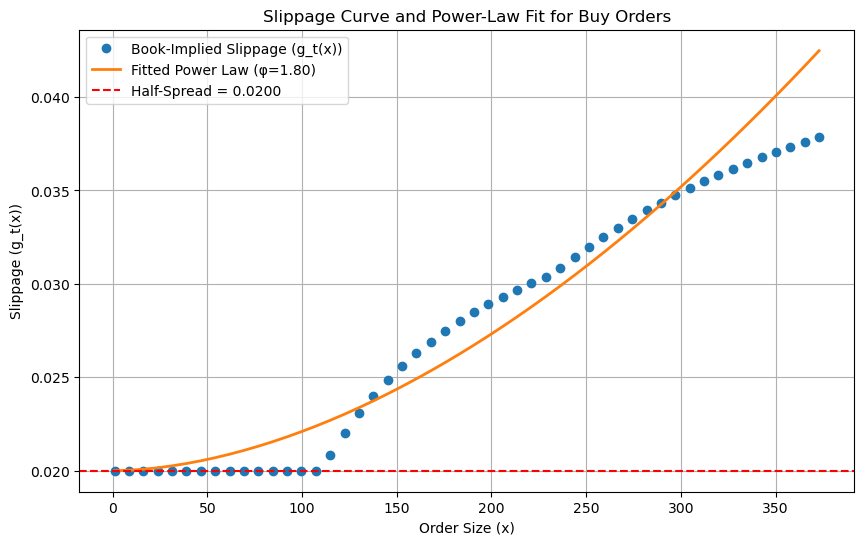

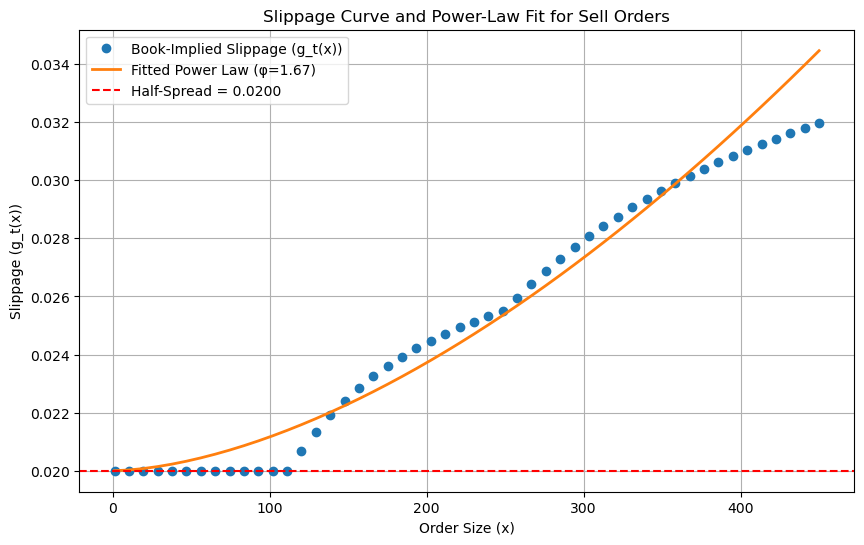

In [9]:
# 7. (Optional) Visualize the results
def plot_slippage_curves(q, g, fit_params, H, D, side):
    g_fit = H + fit_params['theta'] * (q / D) ** fit_params['phi']
    plt.figure(figsize=(10, 6))
    plt.plot(q, g, 'o', label='Book-Implied Slippage (g_t(x))')
    plt.plot(q, g_fit, '-', lw=2, label=f"Fitted Power Law (φ={fit_params['phi']:.2f})")
    plt.axhline(y=H, color='r', linestyle='--', label=f'Half-Spread = {H:.4f}')
    plt.title(f'Slippage Curve and Power-Law Fit for {side.capitalize()} Orders')
    plt.xlabel('Order Size (x)')
    plt.ylabel('Slippage (g_t(x))')
    plt.legend()
    plt.grid(True)
    plt.show()

plot_slippage_curves(q_buy, g_buy, fit_buy, H, D_buy, "buy")
plot_slippage_curves(q_sell, g_sell, fit_sell, H, D_sell, "sell")